This is just practice making a bunch of statistical models in python. I haven't coded in python in a couple years and I never used it in 536, but I should've, so I'm practicing it now during my internship lol. For the linear models, I didn't do any train/test splits, no cross-validation, no prediction, and I don't have any specific research questions to answer. There's some EDA at first, but then the rest is just the bare bones models and nothing else. It would be easy enough to do some prediction or find in-sample and out-of-sample metrics for all of these, however.

For the machine learning models, I still didn't have any specific research questions, but I did do some train/test splits and measured prediction accuracy.

In [1]:
import pandas as pd
import numpy as np

# Read in data
data = pd.read_csv("student_habits_performance.csv")

# Synethetically create new data
df = data.sample(n=10000, replace=True, random_state=123)

# Add noise to numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

np.random.seed(123)
for col in numeric_cols:
    std = df[col].std()
    df[col] += np.random.normal(0, 0.1*std, size=df.shape[0])
    
# Export new synethetic dataset to load it into R
# df.to_csv("synthetic_student_habits_performance.csv", index=False)

EDA

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Get rid of student_id column
df = df.drop(columns=['student_id'])

# Get rid of parental_education_level column (missing values that I don't want to deal with lol)
df = df.drop(columns=['parental_education_level'])

# Encode dummy variables
df['part_time_job'] = df['part_time_job'].map({'Yes': 1, 'No': 0})
df['extracurricular_participation'] = df['extracurricular_participation'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df, columns=['gender'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['diet_quality'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['internet_quality'], drop_first=True, dtype=int)

# Reorder columns to put exam_score first
df = df[['exam_score'] + [col for col in df.columns if col != 'exam_score']]

# Look at first few rows
df.head()

# Look at data types of columns
# df.info()

# Look at summaries of numeric columns


# df.describe()

,exam_score,age,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,extracurricular_participation,gender_Male,gender_Other,diet_quality_Good,diet_quality_Poor,internet_quality_Good,internet_quality_Poor
510,50.159448,16.750081,2.918310,1.821808,2.786824,1,73.300710,5.836182,0.080536,3.071533,1,1,0,1,0,0,0
365,77.274119,23.229595,5.054182,3.257272,0.415936,1,81.647377,4.849538,0.727943,3.258113,0,0,0,1,0,0,1
382,97.456493,20.065143,5.875706,2.211317,2.996244,1,82.366110,7.855572,-0.143782,6.060413,0,1,0,1,0,0,0
322,95.680819,19.653242,6.448155,5.008344,1.587538,0,69.733512,5.397629,0.228693,9.567571,0,1,0,1,0,1,0
988,68.066669,17.866803,3.396264,2.162818,1.342602,0,68.478601,3.940235,3.862628,8.323641,1,1,0,0,0,0,0


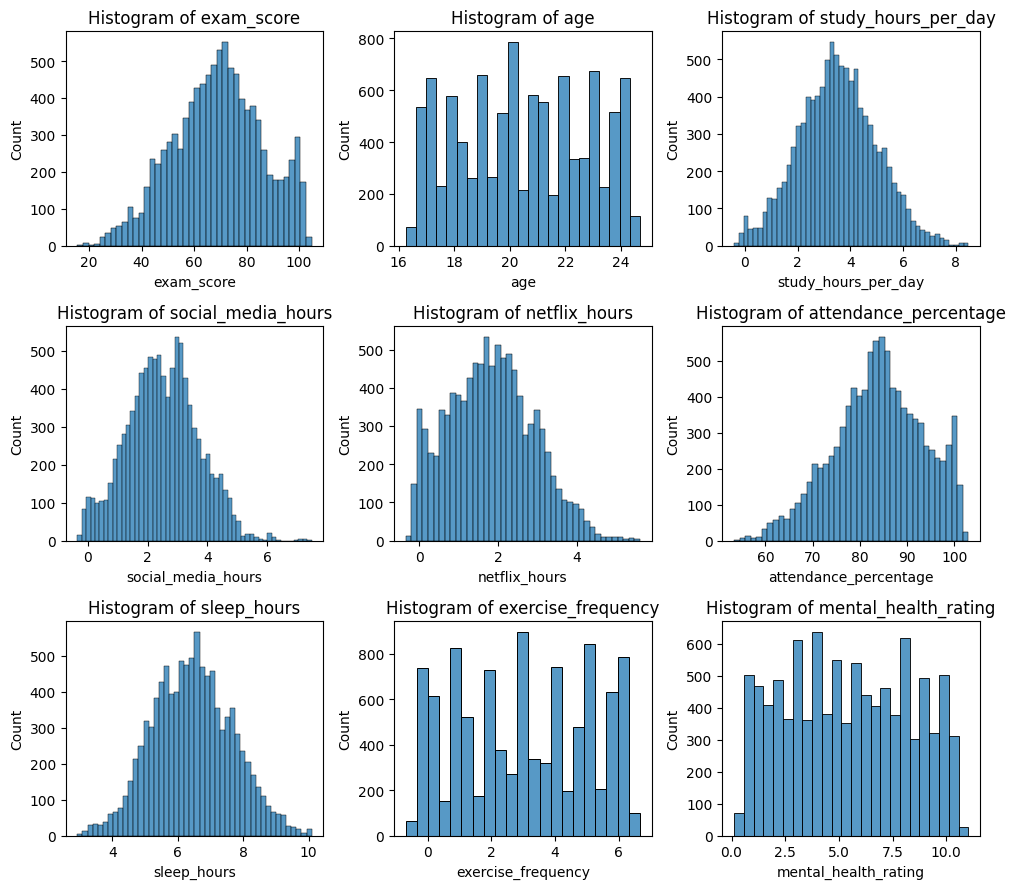

In [4]:
# Histograms

# List of specific columns you want to plot
cols_to_plot = [
    'exam_score', 'age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating',
]

# Choose number of columns in the grid
ncols = 3
nrows = (len(cols_to_plot) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()

# Loop through columns and plot histograms
for i, col in enumerate(cols_to_plot):
    sns.histplot(data=df, x=col, ax=axes[i], kde=False, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

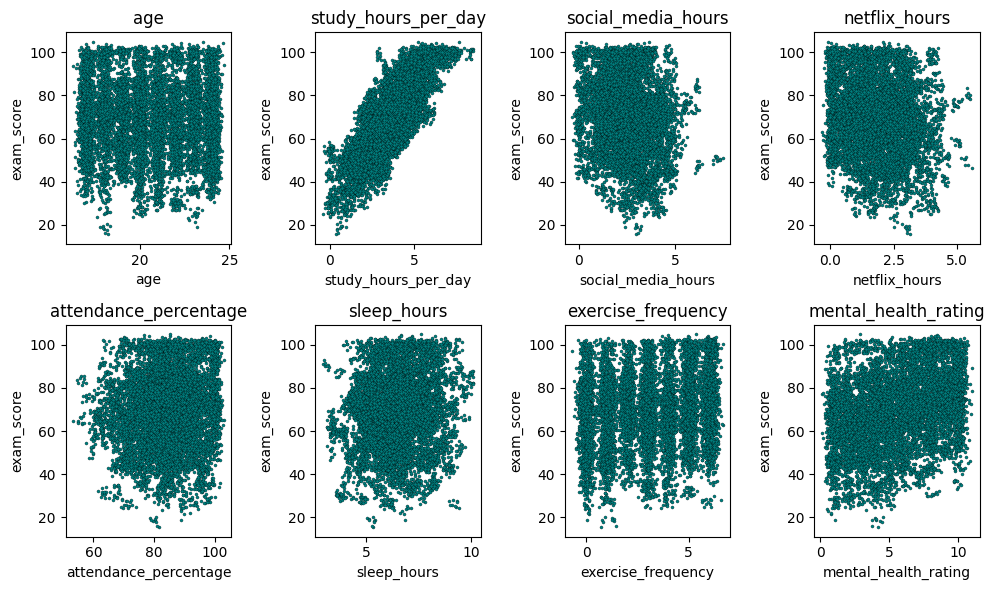

In [5]:
# Satterplots

# Predictors (excluding the response itself)
predictors = [
    'age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'exercise_frequency',
    'mental_health_rating'
]

response = 'exam_score'

# Grid dimensions
ncols = 4
nrows = (len(predictors) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()

# Loop through each predictor and plot scatterplot
for i, col in enumerate(predictors):
    sns.scatterplot(data=df, x=col, y=response, ax=axes[i], color='teal', edgecolor='black', s=5)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(response)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

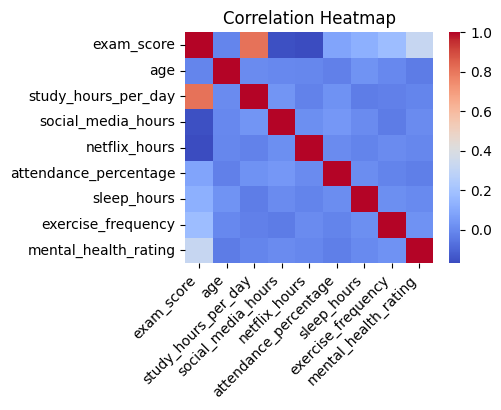

In [6]:
# Correlation heatmap (looks great!)

cols_to_plot = [
    'exam_score', 'age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating',
]

plt.figure(figsize=(4,3))
sns.heatmap(df[cols_to_plot].corr(), cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
plt.show()


# **LINEAR MODELS**

### **OLS**

In [7]:
import statsmodels.formula.api as smf

# Fit the linear regression model using formula syntax
model = smf.ols(
    formula='exam_score ~ age + study_hours_per_day + social_media_hours + netflix_hours + part_time_job + attendance_percentage + sleep_hours + exercise_frequency + mental_health_rating + extracurricular_participation + gender_Male + gender_Other + diet_quality_Good + diet_quality_Poor + internet_quality_Good + internet_quality_Poor',
    data=df
).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     4832.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        09:05:31   Log-Likelihood:                -31674.
No. Observations:               10000   AIC:                         6.338e+04
Df Residuals:                    9983   BIC:                         6.350e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [8]:
# This method does the same thing

import statsmodels.api as sm

# Define X and y
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job',
        'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating',
        'extracurricular_participation', 'gender_Male', 'gender_Other', 'diet_quality_Good',
        'diet_quality_Poor', 'internet_quality_Good', 'internet_quality_Poor']]  # predictors
X = sm.add_constant(X)  # adds the intercept term
y = df['exam_score']     # response

# Fit the model
model = sm.OLS(y, X).fit()

# Summary output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     4832.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        09:05:31   Log-Likelihood:                -31674.
No. Observations:               10000   AIC:                         6.338e+04
Df Residuals:                    9983   BIC:                         6.350e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### **LASSO**

In [9]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define predictors and response
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]
y = df['exam_score']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit Lasso
lasso = Lasso(alpha=0.1)  # regularization parameter of 0.1

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': lasso.coef_
})

# Display
print(coef_df)

                         Variable  Coefficient
0                             age    -0.000000
1             study_hours_per_day    13.963450
2              social_media_hours    -3.036981
3                   netflix_hours    -2.361015
4                   part_time_job     0.079047
5           attendance_percentage     1.343284
6                     sleep_hours     2.382298
7              exercise_frequency     2.927959
8            mental_health_rating     5.498981
9   extracurricular_participation     0.014475
10                    gender_Male    -0.000000
11                   gender_Other     0.091435
12              diet_quality_Good    -0.357136
13              diet_quality_Poor    -0.000000
14          internet_quality_Good    -0.070775
15          internet_quality_Poor    -0.000000


### **Polynomial**

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Define your predictors and target
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]
y = df['exam_score']

# Define which variables to transform
poly_transformer = ColumnTransformer(transformers=[
    ('age^2', PolynomialFeatures(degree=2, include_bias=False), ['age']),
    ('study^2', PolynomialFeatures(degree=2, include_bias=False), ['study_hours_per_day']),
    ('study^3', PolynomialFeatures(degree=3, include_bias=False), ['study_hours_per_day'])
], remainder='passthrough')  # Keep all other variables

# Build the pipeline
model = Pipeline([
    ('poly_features', poly_transformer),
    ('regression', LinearRegression())
])

# Fit the model
model.fit(X, y)

# Get predictions
y_pred = model.predict(X)

In [11]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# Define your predictors and response
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]
y = df['exam_score']

# Define the transformer
poly_transformer = ColumnTransformer(transformers=[
    ('age^2', PolynomialFeatures(degree=2, include_bias=False), ['age']),
    ('study^3', PolynomialFeatures(degree=3, include_bias=False), ['study_hours_per_day'])
], remainder='passthrough')

# Apply the transformation
X_poly = poly_transformer.fit_transform(X)

# Get feature names for the transformed columns
# (this part is optional but makes the summary more readable)
age_features = poly_transformer.named_transformers_['age^2'].get_feature_names_out(['age'])
study_features = poly_transformer.named_transformers_['study^3'].get_feature_names_out(['study_hours_per_day'])
original_features = X.columns.drop(['age', 'study_hours_per_day'])
feature_names = list(age_features) + list(study_features) + list(original_features)

# Create DataFrame and reset index
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
X_poly_df = sm.add_constant(X_poly_df)  # add intercept
X_poly_df = X_poly_df.reset_index(drop=True)
y = y.reset_index(drop=True)

# Fit the model
model = sm.OLS(y, X_poly_df).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     4241.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        09:05:31   Log-Likelihood:                -31489.
No. Observations:               10000   AIC:                         6.302e+04
Df Residuals:                    9980   BIC:                         6.316e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [12]:
# This is the same thing

import statsmodels.api as sm

# Manually create polynomial terms
df['age^2'] = df['age'] ** 2
df['study_hours^2'] = df['study_hours_per_day'] ** 2
df['study_hours^3'] = df['study_hours_per_day'] ** 3

# Prepare predictors (including polynomial terms)
X = df[['age', 'age^2', 'study_hours_per_day', 'study_hours^2', 
        'study_hours^3', 'social_media_hours', 'netflix_hours', 'part_time_job',
        'attendance_percentage', 'sleep_hours', 'exercise_frequency',
        'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]

# Add constant intercept
X = sm.add_constant(X)

# Response variable
y = df['exam_score']

# Fit the model
model = sm.OLS(y, X).fit()

# Print summary (like R's summary())
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     4241.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        09:05:31   Log-Likelihood:                -31489.
No. Observations:               10000   AIC:                         6.302e+04
Df Residuals:                    9980   BIC:                         6.316e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### **Natural Splines**

In [13]:
from patsy import dmatrix
import statsmodels.api as sm
import pandas as pd

# Create spline basis for 'age'
age_spline = dmatrix("cr(age, df=4)", data=df, return_type='dataframe')  # cr does natural spline, bs does B-spline

# Create spline basis for 'study_hours_per_day'
study_spline = dmatrix("cr(study_hours_per_day, df=3)", data=df, return_type='dataframe')

# Combine with other predictors
X = df[['social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage',
        'sleep_hours', 'exercise_frequency', 'mental_health_rating',
        'extracurricular_participation', 'gender_Male', 'gender_Other',
        'diet_quality_Good', 'diet_quality_Poor', 'internet_quality_Good', 'internet_quality_Poor']]  # your other predictors
X = pd.concat([age_spline, study_spline, X], axis=1)

# Add intercept
X = sm.add_constant(X)

# Response variable
y = df['exam_score']

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     4163.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        09:05:31   Log-Likelihood:                -31571.
No. Observations:               10000   AIC:                         6.318e+04
Df Residuals:                    9980   BIC:                         6.333e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### **GAM**

In [14]:
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.families import Gaussian
import numpy as np

# Define spline bases for 'age' and 'study_hours_per_day'
from patsy import dmatrix
age_spline = dmatrix("bs(age, df=4, include_intercept=False)", data=df)  # define B-spline basis
study_spline = dmatrix("bs(study_hours_per_day, df=3, include_intercept=False)", data=df)  # define B-spline basis

# Create full feature matrix
X_splines = np.hstack([age_spline, study_spline])
X_other = df[['social_media_hours', 'netflix_hours', 'part_time_job',
              'attendance_percentage', 'sleep_hours', 'exercise_frequency',
              'mental_health_rating', 'extracurricular_participation',
              'gender_Male', 'gender_Other', 'diet_quality_Good',
              'diet_quality_Poor', 'internet_quality_Good', 'internet_quality_Poor']].to_numpy()

# Combine everything
X = np.hstack([X_splines, X_other])
y = df['exam_score'].to_numpy()

# Fit the GAM model
model = sm.GLM(y, X, family=Gaussian()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9978
Model Family:                Gaussian   Df Model:                           21
Link Function:               Identity   Scale:                          31.874
Method:                          IRLS   Log-Likelihood:                -31487.
Date:                Thu, 29 May 2025   Deviance:                   3.1804e+05
Time:                        09:05:32   Pearson chi2:                 3.18e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0185      0.450      2.261      0.0

### **Logistic Regression**

In [15]:
# Clean up data just a bit (get rid of USER ID column)
ads = pd.read_csv("social_network_ads.csv")
ads = ads.drop(columns=['User ID'])

# Encode Gender variable
ads['Gender'] = ads['Gender'].map({'Male': 1, 'Female': 0})

In [16]:
import statsmodels.api as sm

# X: DataFrame of predictors (make sure to add a constant)
X = sm.add_constant(ads[['Gender', 'Age', 'EstimatedSalary']])
y = ads['Purchased']

# Fit logistic regression
model = sm.Logit(y, X).fit()

# Print summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.344804
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.4711
Time:                        09:05:32   Log-Likelihood:                -137.92
converged:                       True   LL-Null:                       -260.79
Covariance Type:            nonrobust   LLR p-value:                 5.488e-53
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -12.7836      1.359     -9.405      0.000     -15.448     -10.120
Gender        

# **MACHINE LEARNING MODELS**

### **K Nearest Neighbors**

In [17]:
# Continuous Response

from sklearn.neighbors import KNeighborsRegressor  # For regression (predicting continuous y)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]  # make sure these are numeric
y = df['exam_score']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fit KNN model
knn = KNeighborsRegressor(n_neighbors=5)  # k=5 neighbors, adjust as you want
knn.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Calculate RMSE for training set (in-sample)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate RMSE for testing set (out-of-sample)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'In-sample RMSE: {rmse_train:.4f}')
print(f'Out-of-sample RMSE: {rmse_test:.4f}')

In-sample RMSE: 2.0005
Out-of-sample RMSE: 2.7387


In [18]:
# Binary Response

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np

# Define features and target
X = ads[['Gender', 'Age', 'EstimatedSalary']]  # Ensure all features are numeric
y = ads['Purchased']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fit KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict class labels
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Predict probabilities for AUC
y_train_proba = knn.predict_proba(X_train)[:, 1]
y_test_proba = knn.predict_proba(X_test)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Output results
print(f'In-sample Accuracy: {train_accuracy:.4f}')
print(f'In-sample AUC: {train_auc:.4f}')
print(f'Out-of-sample Accuracy: {test_accuracy:.4f}')
print(f'Out-of-sample AUC: {test_auc:.4f}')

# Optional: Detailed classification metrics
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))  # recall is sensitivity (true positive rate)

# Not the best metrics, but it's also a really small dataset, so it doesn't have a ton of data to learn from

In-sample Accuracy: 0.8786
In-sample AUC: 0.9480
Out-of-sample Accuracy: 0.7750
Out-of-sample AUC: 0.8066

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.82      0.83      0.83        77
           1       0.69      0.67      0.68        43

    accuracy                           0.78       120
   macro avg       0.76      0.75      0.75       120
weighted avg       0.77      0.78      0.77       120



### **Support Vector Machines**

In [19]:
# Continuous Response

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]  # make sure these are numeric
y = df['exam_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Train SVR model
svr_model = SVR(kernel='rbf')  # You can also try 'linear' or 'poly'
svr_model.fit(X_train, y_train)

# Predict
y_pred_train = svr_model.predict(X_train)
y_pred_test = svr_model.predict(X_test)

# Evaluate RMSE for training set (in-sample)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Evaluate RMSE for testing set (out-of-sample)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"In-sample RMSE: {rmse_train:.4f}")
print(f"Out-of-sample RMSE: {rmse_test:.4f}")

In-sample RMSE: 13.5663
Out-of-sample RMSE: 13.4650


In [20]:
# Binary Response

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Split features and target
X = ads[['Gender', 'Age', 'EstimatedSalary']]  # Ensure all features are numeric
y = ads['Purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Train SVM (enable probability estimates)
svm_classifier = SVC(kernel='rbf', probability=True)
svm_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = svm_classifier.predict(X_train)
y_test_pred = svm_classifier.predict(X_test)

# Probabilities (needed for AUC)
y_train_proba = svm_classifier.predict_proba(X_train)[:, 1]
y_test_proba = svm_classifier.predict_proba(X_test)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Results
print(f"In-sample Accuracy: {train_acc:.4f}")
print(f"In-sample AUC: {train_auc:.4f}")
print(f"Out-of-sample Accuracy: {test_acc:.4f}")
print(f"Out-of-sample AUC: {test_auc:.4f}")

# Confusion Matrix and Classification Report
print("\nClassification Report - Testing Data:")
print(classification_report(y_test, y_test_pred))

In-sample Accuracy: 0.7893
In-sample AUC: 0.8242
Out-of-sample Accuracy: 0.7250
Out-of-sample AUC: 0.7949

Classification Report - Testing Data:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        77
           1       0.71      0.40      0.51        43

    accuracy                           0.72       120
   macro avg       0.72      0.65      0.66       120
weighted avg       0.72      0.72      0.70       120



### **Decision Tree (CART)**

Regression Tree - In-sample RMSE: 9.4565
Regression Tree - Out-of-sample RMSE: 9.4325


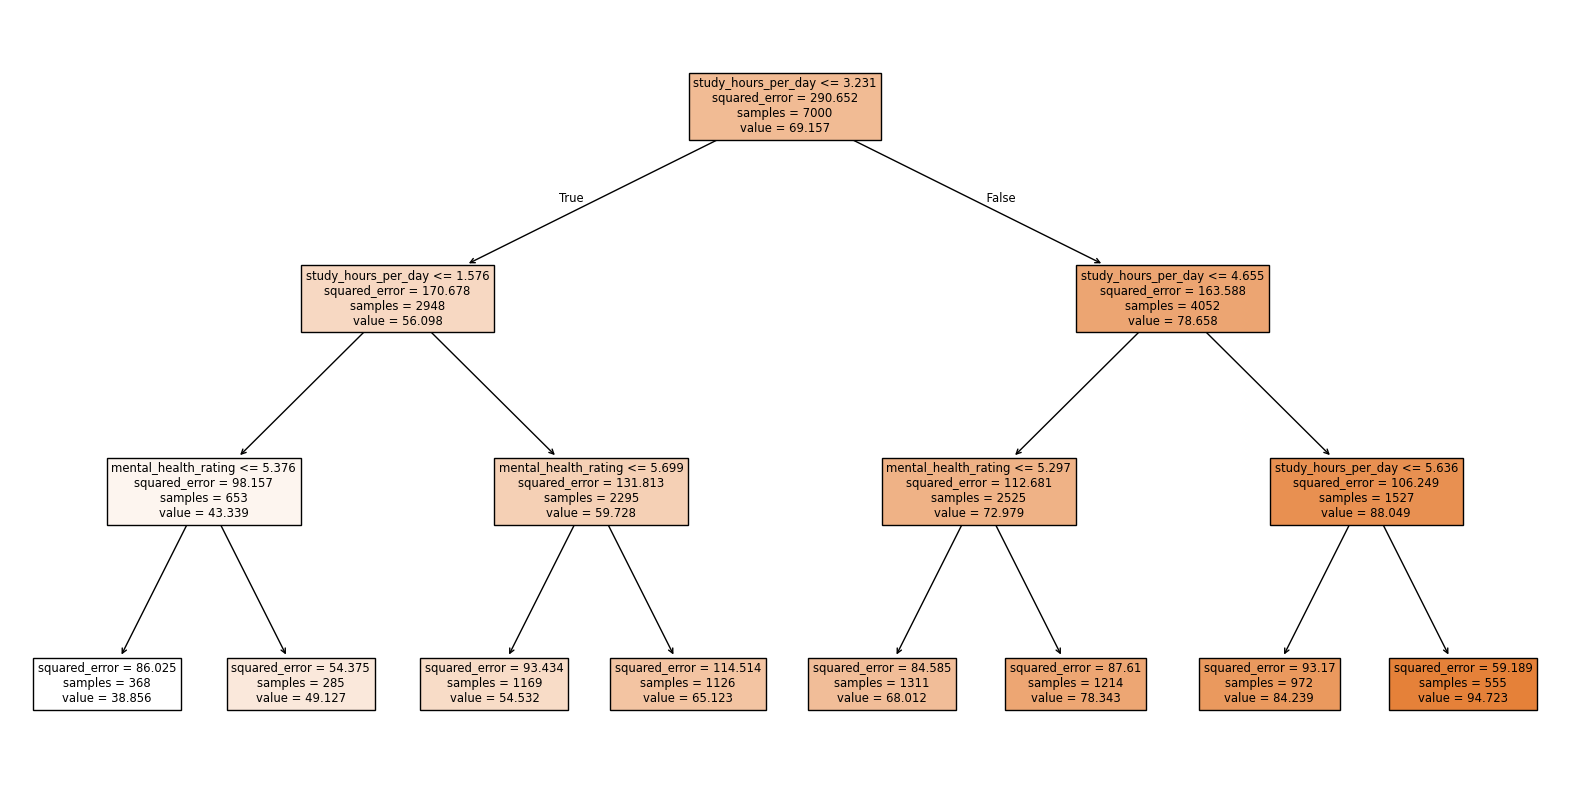

In [21]:
# Continuous Response

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Features and target for regression
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]  # make sure these are numeric
y = df['exam_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fit CART model (regression tree)
reg_tree = DecisionTreeRegressor(max_depth=3, random_state=123)  # change depth here
reg_tree.fit(X_train, y_train)

# Predict
y_train_pred = reg_tree.predict(X_train)
y_test_pred = reg_tree.predict(X_test)

# Evaluation
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Regression Tree - In-sample RMSE: {rmse_train:.4f}")
print(f"Regression Tree - Out-of-sample RMSE: {rmse_test:.4f}")


# Plot decision tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(reg_tree, feature_names=X.columns, filled=True)
plt.show()

In-sample Accuracy: 0.9286
In-sample AUC: 0.9756
Out-of-sample Accuracy: 0.8917
Out-of-sample AUC: 0.9156


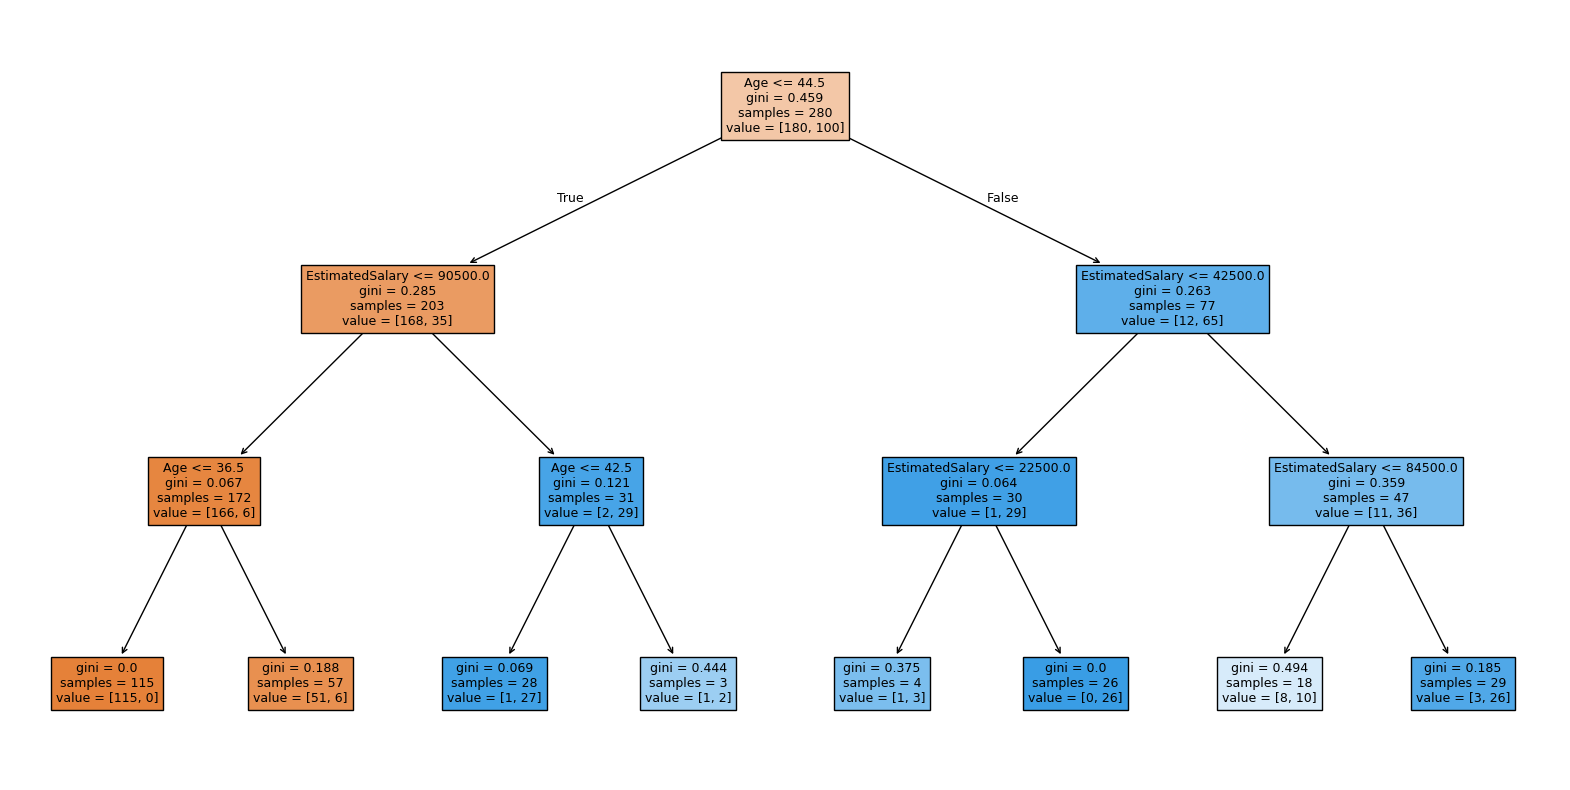

In [22]:
# Binary Response

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Features and target for classification
X = ads[['Gender', 'Age', 'EstimatedSalary']]  # Ensure all features are numeric
y = ads['Purchased']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fit CART model (classification tree)
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=123)  # change depth here
clf_tree.fit(X_train, y_train)

# Predict
y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)
y_train_proba = clf_tree.predict_proba(X_train)[:, 1]
y_test_proba = clf_tree.predict_proba(X_test)[:, 1]

# Evaluation
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

print(f"In-sample Accuracy: {acc_train:.4f}")
print(f"In-sample AUC: {auc_train:.4f}")
print(f"Out-of-sample Accuracy: {acc_test:.4f}")
print(f"Out-of-sample AUC: {auc_test:.4f}")


# Plot decision tree

from sklearn.tree import DecisionTreeRegressor, plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_tree, feature_names=X.columns, filled=True)
plt.show()

### **Random Forest**

In [23]:
# Continuous Response

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# X and y should be numeric
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]  # make sure these are numeric
y = df['exam_score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit random forest regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predictions
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

# Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("In-sample RMSE:", rmse_train)
print("Out-of-sample RMSE:", rmse_test)

In-sample RMSE: 1.1742206483631115
Out-of-sample RMSE: 3.0871785458288548


In [24]:
# Binary Response

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# X and y should be prepared ahead of time
X = ads[['Gender', 'Age', 'EstimatedSalary']]  # Ensure all features are numeric
y = ads['Purchased']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

# Probabilities for AUC
y_train_proba = rf_clf.predict_proba(X_train)[:, 1]
y_test_proba = rf_clf.predict_proba(X_test)[:, 1]

# Metrics
print("In-sample Accuracy:", accuracy_score(y_train, y_train_pred))
print("In-sample AUC:", roc_auc_score(y_train, y_train_proba))
print("Out-of-sample Accuracy:", accuracy_score(y_test, y_test_pred))
print("Out-of-sample AUC:", roc_auc_score(y_test, y_test_proba))
print("\nClassification Report (OOS):")
print(classification_report(y_test, y_test_pred))

In-sample Accuracy: 0.9964285714285714
In-sample AUC: 0.9999716938405797
Out-of-sample Accuracy: 0.8916666666666667
Out-of-sample AUC: 0.9667735354124162

Classification Report (OOS):
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        73
           1       0.87      0.85      0.86        47

    accuracy                           0.89       120
   macro avg       0.89      0.88      0.89       120
weighted avg       0.89      0.89      0.89       120



### **Boosting**

In [25]:
# Continuous Response

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# X and y should be numeric
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]  # make sure these are numeric
y = df['exam_score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit random forest regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predictions
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

# Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("In-sample RMSE:", rmse_train)
print("Out-of-sample RMSE:", rmse_test)

In-sample RMSE: 1.1742206483631115
Out-of-sample RMSE: 3.0871785458288548


In [26]:
# Binary Response

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Prepare X and y (numeric predictors and binary response)
X = ads[['Gender', 'Age', 'EstimatedSalary']]  # Ensure all features are numeric
y = ads['Purchased']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)

# Predictions
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

# Probabilities for AUC
y_train_proba = gb_clf.predict_proba(X_train)[:, 1]
y_test_proba = gb_clf.predict_proba(X_test)[:, 1]

# Metrics
print("In-sample Accuracy:", accuracy_score(y_train, y_train_pred))
print("In-sample AUC:", roc_auc_score(y_train, y_train_proba))
print("Out-of-sample Accuracy:", accuracy_score(y_test, y_test_pred))
print("Out-of-sample AUC:", roc_auc_score(y_test, y_test_proba))
print("\nClassification Report (OOS):")
print(classification_report(y_test, y_test_pred))

In-sample Accuracy: 0.9678571428571429
In-sample AUC: 0.9975939764492753
Out-of-sample Accuracy: 0.9166666666666666
Out-of-sample AUC: 0.9702710580005829

Classification Report (OOS):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        73
           1       0.91      0.87      0.89        47

    accuracy                           0.92       120
   macro avg       0.92      0.91      0.91       120
weighted avg       0.92      0.92      0.92       120



### **BART**

I'm sure there are simple ways to implement BART in python, but I never was able to find a way to do it. I tried using python packages, using GitHub code from others, and connecting R to python. The R method could've worked, but I'd rather just do it all in R if I'm going to have to do it there anyway just to pipe it into python. But it was still a good exercise in seeing the strengths and weaknesses of different coding languages!

In [27]:
# Continuous Response

"""
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro

# Enable auto conversion
pandas2ri.activate()

# Push dataset (df) into R
ro.globalenv["df"] = pandas2ri.py2rpy(df)

# Source the R script
r.source("bart_cont_for_python.R")

# Pull outputs from R
yhat_test = np.array(r["yhat_test_mean_out"])
ci_lower = np.array(r["ci_lower_out"])
ci_upper = np.array(r["ci_upper_out"])
rmse_train = float(r["rmse_train_out"][0])
rmse_test = float(r["rmse_test_out"][0])

# Example: Print results
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

# Optionally: Combine predictions and intervals into a DataFrame
pred_df = pd.DataFrame({
    "Predicted": yhat_test,
    "Lower95CI": ci_lower,
    "Upper95CI": ci_upper
})

print(pred_df.head())
"""

'\nimport pandas as pd\nimport numpy as np\nfrom rpy2.robjects import r, pandas2ri\nimport rpy2.robjects as ro\n\n# Enable auto conversion\npandas2ri.activate()\n\n# Push dataset (df) into R\nro.globalenv["df"] = pandas2ri.py2rpy(df)\n\n# Source the R script\nr.source("bart_cont_for_python.R")\n\n# Pull outputs from R\nyhat_test = np.array(r["yhat_test_mean_out"])\nci_lower = np.array(r["ci_lower_out"])\nci_upper = np.array(r["ci_upper_out"])\nrmse_train = float(r["rmse_train_out"][0])\nrmse_test = float(r["rmse_test_out"][0])\n\n# Example: Print results\nprint("Train RMSE:", rmse_train)\nprint("Test RMSE:", rmse_test)\n\n# Optionally: Combine predictions and intervals into a DataFrame\npred_df = pd.DataFrame({\n    "Predicted": yhat_test,\n    "Lower95CI": ci_lower,\n    "Upper95CI": ci_upper\n})\n\nprint(pred_df.head())\n'

In [28]:
# Another attempt

"""
import pandas as pd
import numpy as np
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

# Activate pandas <-> R DataFrame conversion
pandas2ri.activate()

# Define which columns are predictors and which is response
X = df.drop(columns="exam_score")
y = df["exam_score"]

# Push to R
ro.globalenv["X"] = pandas2ri.py2rpy(X)
ro.globalenv["y"] = pandas2ri.py2rpy(y)

# Load BART and run the model in R
ro.r(
# Prepare your data: X numeric matrix, y numeric vector
X <- df[, c('age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
            'part_time_job', 'attendance_percentage', 'sleep_hours',
            'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
            'genderMale', 'genderOther', 'diet_qualityGood', 'diet_qualityPoor',
            'internet_qualityGood', 'internet_qualityPoor')]
y <- df$exam_score

# Train-test split (70%-30%)
set.seed(42)
train_idx <- createDataPartition(y, p = 0.7, list = FALSE)
X_train <- as.matrix(X[train_idx, ])
y_train <- y[train_idx]
X_test <- as.matrix(X[-train_idx, ])
y_test <- y[-train_idx]

# Fit BART model
set.seed(123)
bart_model <- wbart(x.train = X_train, y.train = y_train, x.test = X_test)

# --- In-sample predictions ---
yhat_train_mean <- colMeans(bart_model$yhat.train)
rmse_train <- sqrt(mean((y_train - yhat_train_mean)^2))

# --- Out-of-sample predictions ---
yhat_test_mean <- colMeans(bart_model$yhat.test)
rmse_test <- sqrt(mean((y_test - yhat_test_mean)^2))
)

# Get predictions back into Python
rmse_train = np.array(ro.r('rmse_train'))
rmse_test = np.array(ro.r('rmse_test'))
preds_mean = preds.mean(axis=0)  # Average across posterior samples
"""

'\nimport pandas as pd\nimport numpy as np\nfrom rpy2.robjects import pandas2ri\nimport rpy2.robjects as ro\n\n# Activate pandas <-> R DataFrame conversion\npandas2ri.activate()\n\n# Define which columns are predictors and which is response\nX = df.drop(columns="exam_score")\ny = df["exam_score"]\n\n# Push to R\nro.globalenv["X"] = pandas2ri.py2rpy(X)\nro.globalenv["y"] = pandas2ri.py2rpy(y)\n\n# Load BART and run the model in R\nro.r(\n# Prepare your data: X numeric matrix, y numeric vector\nX <- df[, c(\'age\', \'study_hours_per_day\', \'social_media_hours\', \'netflix_hours\',\n            \'part_time_job\', \'attendance_percentage\', \'sleep_hours\',\n            \'exercise_frequency\', \'mental_health_rating\', \'extracurricular_participation\',\n            \'genderMale\', \'genderOther\', \'diet_qualityGood\', \'diet_qualityPoor\',\n            \'internet_qualityGood\', \'internet_qualityPoor\')]\ny <- df$exam_score\n\n# Train-test split (70%-30%)\nset.seed(42)\ntrain_idx <- cre

In [29]:
# Binary Response



### **Neural Network**

In [30]:
# Continuous Response

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Example data
X = df[['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
        'part_time_job', 'attendance_percentage', 'sleep_hours',
        'exercise_frequency', 'mental_health_rating', 'extracurricular_participation',
        'gender_Male', 'gender_Other', 'diet_quality_Good', 'diet_quality_Poor',
        'internet_quality_Good', 'internet_quality_Poor']]  # make sure these are numeric
y = df['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Neural network regressor
nn_reg = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_reg.fit(X_train, y_train)

# Predictions
y_train_pred = nn_reg.predict(X_train)
y_test_pred = nn_reg.predict(X_test)

# Evaluation
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

Train RMSE: 5.795033557082709
Test RMSE: 5.724770716099835


In [31]:
# Binary Response

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Define X and y
X = ads[['Gender', 'Age', 'EstimatedSalary']]  # Ensure all features are numeric
y = ads['Purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Neural network classifier
nn_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_clf.fit(X_train, y_train)

# Predictions
y_train_pred = nn_clf.predict(X_train)
y_train_proba = nn_clf.predict_proba(X_train)[:, 1]
y_test_pred = nn_clf.predict(X_test)
y_test_proba = nn_clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_proba))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_proba))

Train Accuracy: 0.6428571428571429
Train AUC: 0.31388888888888883
Test Accuracy: 0.6416666666666667
Test AUC: 0.3074599818785865
